# This is for wwall subroutine in vacuum_vac.f, completed

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
using JPEC, Plots

  Activating project at `~/Desktop/code/GPEC_hackaton/JPEC`


In [2]:
vac_math_path = joinpath(@__DIR__, "..","src", "Vacuum", "Vacuum_math.jl");
include(vac_math_path)
vac_data_path = joinpath(@__DIR__, "..","src", "Vacuum", "Vacuum_data.jl");
include(vac_data_path)

VacuumSettingsType

In [3]:
vacuum = VacuumSettingsType()

VacuumSettingsType(Modes(480, (0, 0, 0, 0, 0, 0, 0, 1, 0), true, 1), Vacdat(6, 0.05, 1.5, 0.0, 0.5, 0.05, 500, 1.0e-5, 37, 6, 0, 0, 15.01, 0.001, 1), Shape(0, 0, 0, 100.0, 1.0, 20.0, 170.0, 1.0, 0.0, 1.0, 0.932, 17.0, 0.02, 2.5, 1.0, 0.0), Diagns(false, 0, 0, 1, 128, 0, 3, 1, 0.0, 32, 0.01, 1.6, 0.5, 1.0, 0.001, 21, 21, 0, 6, 11, 0.02, 0.7, 2.7, -1.5, 1.5, 2), Sprk(0, 0, 16, 0, 0.0, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 0, 1.6, [1.6, 1.6, 1.6, 1.6, 1.6, 1.0, 1.6, 1.6, 1.6, 1.6  …  1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6]), false)

In [4]:
"""
    bounds(x, z, istart, ifinish)

Calculates the minimum and maximum X and Z coordinates within a specified range of two input vectors.

# Arguments
- `x::AbstractVector{<:Real}`: Input vector for X coordinates.
- `z::AbstractVector{<:Real}`: Input vector for Z coordinates.
- `istart::Integer`: Starting index for the range (1-based).
- `ifinish::Integer`: Ending index for the range (1-based).

# Returns
- A `Tuple{Real, Real, Real, Real}` containing (xmin, xmax, zmin, zmax).

# Throws
- `ArgumentError`: If indices are out of bounds or `istart > ifinish`.
"""
function bounds(x::AbstractVector{<:Real}, z::AbstractVector{<:Real}, istart::Integer, ifinish::Integer)

    if istart > ifinish
        throw(ArgumentError("Starting index ($istart) cannot be greater than ending index ($ifinish)."))
    end
    
    if !(1 <= istart <= length(x)) || !(1 <= ifinish <= length(x))
        throw(ArgumentError("Indices [$istart, $ifinish] are out of bounds for x vector with length $(length(x))."))
    end
    if !(1 <= istart <= length(z)) || !(1 <= ifinish <= length(z))
        throw(ArgumentError("Indices [$istart, $ifinish] are out of bounds for z vector with length $(length(z))."))
    end

    range = istart:ifinish
    xmin = minimum(view(x, range))
    xmax = maximum(view(x, range))
    zmin = minimum(view(z, range))
    zmax = maximum(view(z, range))

    return xmin, xmax, zmin, zmax
end

bounds

In [5]:
"""
    eqarcw(xin, zin, mw1)

This function performs arc length re-parameterization of a 2D curve. It takes an
input curve defined by `(xin, zin)` coordinates and re-samples it such that
the new points `(xout, zout)` are equally spaced in arc length.

# Arguments
- `xin::AbstractVector{Float64}`: Array of x-coordinates of the input curve.
- `zin::AbstractVector{Float64}`: Array of z-coordinates of the input curve.
- `mw1::Int`: Number of points in the input and output curves.

# Returns
- `xout::Vector{Float64}`: Array of x-coordinates of the arc-length re-parameterized curve.
- `zout::Vector{Float64}`: Array of z-coordinates of the arc-length re-parameterized curve.
- `ell::Vector{Float64}`: Array of cumulative arc lengths for the input curve.
- `thgr::Vector{Float64}`: Array of re-parameterized 'theta' values corresponding to equal arc lengths.
- `thlag::Vector{Float64}`: Array of normalized 'theta' values for the input curve (0 to 1).
"""
function eqarcw(xin::Vector{Float64}, zin::Vector{Float64}, mw1::Int)
    
    thlag = zeros(Float64, mw1)
    ell = zeros(Float64, mw1)
    thgr = zeros(Float64, mw1)
    xout = zeros(Float64, mw1)
    zout = zeros(Float64, mw1)

    # Initialize thlag as normalized parameter from 0 to 1
    for iw in 1:mw1
        thlag[iw] = (1.0 / (mw1 - 1)) * (iw - 1)
    end

    # Calculate cumulative arc length
    ell[1] = 1.0e-8 # Small non-zero initial length
    for iw in 2:mw1
        thet = (thlag[iw] + thlag[iw - 1]) / 2.0
        
        # Get derivative of xin with respect to thlag
        lagrange1d!(thlag, xin, mw1, 3, thet, nothing , d_xin_d_thlag)
        lagrange1d!(thlag, zin, mw1, 3, thet, nothing, d_zin_d_thlag)
        
        # Calculate arc length segment
        xtzt = norm([d_xin_d_thlag, d_zin_d_thlag])
        ell[iw] = ell[iw - 1] + xtzt / (mw1 - 1)
    end

    # Re-parameterize based on equal arc lengths
    for i in 1:mw1
        elgr = (ell[mw1] / (mw1 - 1)) * (i - 1)
        # Interpolate thlag based on equal arc lengths
        thgr[i], _ = lag(ell, thlag, mw1, 3, elgr, 0)
    end

    # Get xout and zout using the re-parameterized thgr
    for i in 1:mw1
        ttt = thgr[i]
        # Interpolate xin, zin at ttt
        lagrange1d!(thlag, xin, mw1, 3, ttt, xout[i], nothing)
        lagrange1d(thlag, zin, mw1, 3, ttt, zout[i], nothing)
    end
    return xout, zout, ell, thgr, thlag # Explicitly return all calculated arrays
end

eqarcw

### adjustb 

In [6]:
"""
    adjustb(betin, betout_ref, a_, bw_, cw_, dw_, xmaj_, plrad_, ishape_)

Adjusts the `betin` angle based on the `ishape_` and other wall/plasma parameters.
This function takes `betout_ref` as a `Ref` so it can modify the output value in-place.

# Arguments
- `betin::Float64`: Input angle.
- `a_::Float64`: Wall parameter.
- `bw_::Float64`: Wall parameter (elongation or height).
- `cw_::Float64`: Wall parameter (center or offset).
- `dw_::Float64`: Wall parameter (triangularity).
- `xmaj_::Float64`: Magnetic axis X coordinate.
- `plrad_::Float64`: Plasma radius.
- `ishape_::Int`: Integer indicating the wall shape type.
"""
function adjustb(betin::Float64, a_::Float64, bw_::Float64, cw_::Float64, dw_::Float64,
                 xmaj_::Float64, plrad_::Float64, ishape_::Int)

    # These local variables r0 and r are correctly scoped and used for intermediate calculations.
    local r0::Float64 = 0.0
    local r::Float64 = 0.0

    if ishape_ == 31
        r0 = cw_
        r  = a_
    elseif ishape_ == 21
        r0 = xmaj_ + cw_ * plrad_
        r  = plrad_ * (1.0 + a_ - cw_)
    else
        @warn "adjustb: Unsupported ishape_ value: $ishape_. r0 and r will remain 0.0."
    end

    bet2 = betin # No change here, bet2 is a local copy of betin

    if bw_ == 0.0
        @warn "adjustb: Division by zero detected (bw_ is 0.0). Setting betout_ref to NaN."
        betout = NaN # Correctly assign NaN to the value inside the Ref
        return nothing
    end
    betout = abs(atan(tan(bet2) / bw_)) # Correctly assign to the value inside the Ref

    return betout
end


adjustb

### d3dvesl, d3dwall

In [7]:
"""
    d3dvesl!(r0, z0, a0, e0, ar, az, nval, zst, r, z, npts, ier_ref)

Defines the shape of the DIII-D vacuum vessel based on Fourier series coefficients.

# Arguments
- `r0::Float64`: Reference major radius.
- `z0::Float64`: Reference vertical position.
- `a0::Float64`: Minor radius scaling factor.
- `e0::Float64`: Elongation scaling factor.
- `ar::Vector{Float64}`: Fourier coefficients for radial component.
- `az::Vector{Float64}`: Fourier coefficients for vertical component.
- `nval::Int`: Number of Fourier coefficients.
- `zst::Float64`: Starting vertical position for calculation (used in an unused branch).
- `r::Vector{Float64}`: Output vector for R coordinates of the wall (modified in-place).
- `z::Vector{Float64}`: Output vector for Z coordinates of the wall (modified in-place).
- `npts::Int`: Number of points to generate for the wall.
- `ier_ref::Ref{Int}`: Error flag (0 for success, 1 for error) passed by reference.
"""
function d3dvesl!(r0::Float64, z0::Float64, a0::Float64, e0::Float64,
                 ar::Vector{Float64}, az::Vector{Float64}, nval::Int, zst::Float64,
                 r::Vector{Float64}, z::Vector{Float64}, npts::Int, ier_ref::Int)

    pii = acos(-1.0) # Using Julia's built-in pi constant from π
    ier_ref = 0 # Initialize error flag

    local arcst::Float64

    if abs(z0 - zst) <= 1.0e-6
        # This branch is usually taken, as zstart is set to 0.0 in d3dwall
        arcst = 0.0
    else
        local isgn::Int
        local zpcmp::Float64
        local arci::Float64
        local arcf::Float64
        local dfi::Float64
        local arca::Float64
        local zza::Float64
        local arcb::Float64
        local zzb::Float64
        local ackb::Float64
        local arcc::Float64
        local zzc::Float64
        local ackc::Float64
        local dzp::Float64
        local dzm::Float64
        local dzt::Float64
        local dcf1::Float64
        local dcf2::Float64
        local zdf::Float64

        if z0 < zst
            isgn = +1
        end
        if z0 > zst
            isgn = -1
        end
        zpcmp = (zst - z0) / (a0 * e0)
        arci = 0.0
        arcf = 0.5 * pii
        dfi = (arcf - arci) / npts
        arca = arci
        zza = 0.0
        for j = 2:npts
            arcb = arca + isgn * dfi
            zzb = 0.0
            for k = 1:nval
                ackb = k * arcb
                zzb = zzb + az[k] * sin(ackb)
            end # 5 continue
            if (zza - zpcmp) * (zzb - zpcmp) <= 0.0
                arcc = arcb + isgn * dfi
                zzc = 0.0
                for k = 1:nval
                    ackc = k * arcc
                    zzc = zzc + az[k] * sin(ackc)
                end # 10 continue
                @goto label_25
            else
                arca = arcb
                zza = zzb
            end
        end # 20 continue
        ier_ref[] = 1
        return
        @label label_25 # 25 continue
        dzp = zzc - zzb
        dzm = zzb - zza
        dzt = zzc - zza
        dcf1 = dfi * (dzm / dzp + dzp / dzm) / dzt
        dcf2 = dfi * (1.0 / dzp - 1.0 / dzm) / dzt
        zdf = zpcmp - zzb
        arcst = arcb + dcf1 * zdf + dcf2 * zdf * zdf
    end

    arc0 = arcst
    arc1 = arcst + 2.0 * pii
    darc = (arc1 - arc0) / npts

    for j = 1:npts
        arc = arc0 + (j - 1.0) * darc
        sumr = 0.0
        sumz = 0.0
        for k = 1:nval
            arck = k * arc
            sumr = sumr + ar[k] * cos(arck)
            sumz = sumz + az[k] * sin(arck)
        end # 50 continue
        rpval = r0 + a0 * sumr
        zpval = z0 - e0 * a0 * sumz
        r[j] = rpval
        z[j] = zpval
    end # 100 continue

    return nothing
end

d3dvesl!

In [8]:
using Printf # For @printf

"""
    d3dwall!(xwall, ywall, mthh, iomod, iotty1, rext_in, zlim_val_in)

Defines the shape of the DIII-D wall by calling `d3dvesl`.

# Arguments
- `xwall::Vector{Float64}`: Output vector for X coordinates of the DIII-D wall (modified in-place).
- `ywall::Vector{Float64}`: Output vector for Y (Z in Cartesian) coordinates of the DIII-D wall (modified in-place).
- `mthh::Int`: Number of points to generate for the wall.
- `iomod::IO`: Output stream for general messages.
- `iotty1::IO`: Output stream for terminal messages.
- `rext_in::Float64`: External scaling factor for the wall.
- `zlim_val_in::Float64`: Global z-limit value (used in `d3dvesl` implicitly).
"""
function d3dwall!(xwall::Vector{Float64}, ywall::Vector{Float64}, mthh::Int,
                 iomod::IO, iotty1::IO, rext_in::Float64, zlim_val_in::Float64)

    ncdf = 26
    rwi = [
        1.0, 0.05526794, -0.1738114, 0.01850757, 0.03714965, -0.02882647,
        -0.002357329, 0.009548103, -0.01214923, -0.001853416, 0.006837493,
        -0.001711245, 0.002270762, 0.003689963, -0.003959393, -0.001098017,
        0.003745465, -0.0002157904, -0.0003977743, -0.0002725623,
        -0.001005857, -0.000004579016, 0.002396789, -0.0007057043,
        0.001158347, 0.0003552319
    ]
    zwi = [
        1.0, -0.03236632, -0.1629422, 0.06013983, 0.01167756, -0.02579542,
        0.01626464, -0.002085857, -0.009098639, 0.01022163, -0.004388253,
        -0.009367258, 0.008308497, 0.004765150, -0.004611675, -0.001121423,
        -0.0002501100, 0.4282634e-03, 0.2669702e-02, -0.1073800e-02, # Corrected: -0.1073800d-02 from Fortran
        -0.2191338e-02, 0.1328267e-02, 0.5050959e-03, -0.5758863e-03,
        0.9348883e-03, 0.7094351e-03
    ]

    rwall0 = 1.6400000
    zwall0 = 0.0000000
    awall0 = 0.8839410
    ewall0 = 1.4037020

    nwcoef = ncdf

    rwll = rwall0
    zwll = zwall0
    awll = awall0 * rext_in # Use rext_in here
    ewll = ewall0

    # In the Fortran code, `zstart = zlim` and then `zlim = 0.0`, followed by `zstart = 0.0`.
    # This effectively makes `zstart` 0.0 for the call to `d3dvesl`.
    zstart = 0.0 # This overwrites zlim_val_in for the purpose of d3dvesl.

    nwalp = mthh

    ier_ref = 0 # Julia's way to pass an integer by reference for modification
    d3dvesl!(rwll, zwll, awll, ewll, rwi, zwi, nwcoef, zstart, xwall, ywall, nwalp, ier_ref)
    ier = ier_ref[] # Get the value from the reference

    @printf(iomod, "ier in d3dwall = %3d\n", ier)
    @printf(iotty1, "ier in d3dwall = %3d\n", ier)

    xwall[mthh+1] = xwall[1]
    ywall[mthh+1] = ywall[1]
end

d3dwall!

### Test d3dwall, d3dvesl

In [22]:

# 1. Define input parameters
# mthh is the number of points for the wall, also equivalent to npts for d3dvesl!
mthh_val = 512 # A reasonable number of points for a smooth curve
rext_val = 1.0 # External scaling factor, usually 1.0 for standard DIII-D wall
zlim_val = 0.0 # This value is overwritten to 0.0 inside d3dwall! for zstart

# 2. Initialize output vectors
# xwall and ywall need to be mthh_val + 1 long because d3dwall! adds the first point at the end
xwall_output = Vector{Float64}(undef, mthh_val + 1)
ywall_output = Vector{Float64}(undef, mthh_val + 1)

# 3. Set up IO streams
# `devnull` suppresses output. Use `stdout` to see messages in the console.
iomod_stream = devnull # You can change this to stdout if you want to see "ier in d3dwall" for iomod
iotty1_stream = stdout # Prints "ier in d3dwall" to your terminal

# 4. Call the d3dwall! function
println("Calling d3dwall! with mthh_val = $mthh_val and rext_val = $rext_val...")
d3dwall!(xwall_output, ywall_output, mthh_val, iomod_stream, iotty1_stream, rext_val, zlim_val)
println("d3dwall! call completed. Check output below:")

# 5. Verify the results
println("\n--- Verification ---")

# Check if the output vectors are populated
@printf "Is xwall_output empty? %s\n" isempty(xwall_output) ? "Yes" : "No"
@printf "Is ywall_output empty? %s\n" isempty(ywall_output) ? "Yes" : "No"

# Check the lengths
@printf "Length of xwall_output: %d (Expected: %d)\n" length(xwall_output) (mthh_val + 1)
@printf "Length of ywall_output: %d (Expected: %d)\n" length(ywall_output) (mthh_val + 1)

# Check if the first and last points match (as d3dwall! explicitly sets them)
# Use ≈ for approximate equality with floating-point numbers
@printf "xwall_output[1] (%f) vs xwall_output[end] (%f): Match? %s\n" xwall_output[1] xwall_output[end] (xwall_output[1] ≈ xwall_output[end]) ? "Yes" : "No"
@printf "ywall_output[1] (%f) vs ywall_output[end] (%f): Match? %s\n" ywall_output[1] ywall_output[end] (ywall_output[1] ≈ ywall_output[end]) ? "Yes" : "No"

# Print a few sample points to visually inspect the shape (optional, for debugging)
println("\n--- Sample Points (R, Z) ---")
for i in 1:min(5, mthh_val)
    @printf "Point %3d: R = %8.4f, Z = %8.4f\n" i xwall_output[i] ywall_output[i]
end
println("...")
for i in max(1, mthh_val-4):mthh_val+1
    @printf "Point %3d: R = %8.4f, Z = %8.4f\n" i xwall_output[i] ywall_output[i]
end

using Plots
plot(xwall_output, ywall_output, seriestype=:scatter, legend=false, aspect_ratio=:equal,
     xlabel="R (m)", ylabel="Z (m)", title="DIII-D Vacuum Vessel Shape")
savefig("d3d_vessel_shape.png") # Saves the plot to a file
println("\nPlot saved to d3d_vessel_shape.png")

Calling d3dwall! with mthh_val = 512 and rext_val = 1.0...
ier in d3dwall =   0
d3dwall! call completed. Check output below:

--- Verification ---
Is xwall_output empty? No
Is ywall_output empty? No
Length of xwall_output: 513 (Expected: 513)
Length of ywall_output: 513 (Expected: 513)
xwall_output[1] (2.446648) vs xwall_output[end] (2.446648): Match? Yes
ywall_output[1] (0.000000) vs ywall_output[end] (0.000000): Match? Yes

--- Sample Points (R, Z) ---
Point   1: R =   2.4466, Z =   0.0000
Point   2: R =   2.4465, Z =  -0.0105
Point   3: R =   2.4462, Z =  -0.0210
Point   4: R =   2.4456, Z =  -0.0313
Point   5: R =   2.4449, Z =  -0.0415
...
Point 508: R =   2.4441, Z =   0.0516
Point 509: R =   2.4449, Z =   0.0415
Point 510: R =   2.4456, Z =   0.0313
Point 511: R =   2.4462, Z =   0.0210
Point 512: R =   2.4465, Z =   0.0105
Point 513: R =   2.4466, Z =   0.0000

Plot saved to d3d_vessel_shape.png


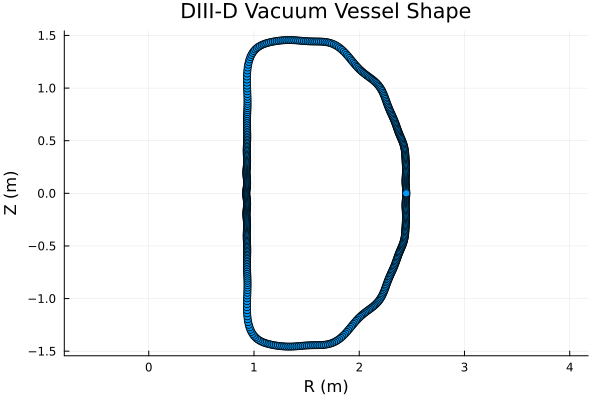

In [23]:
plot(xwall_output, ywall_output, seriestype=:scatter, legend=false, aspect_ratio=:equal,
     xlabel="R (m)", ylabel="Z (m)", title="DIII-D Vacuum Vessel Shape")

In [26]:
print(xwall_output)

[2.4466479142260074, 2.4465272039168457, 2.446174577575545, 2.445617740100518, 2.4449002418368146, 2.444077786336509, 2.4432135273529227, 2.442372770025064, 2.4416175419623047, 2.4410015085801, 2.4405656729064793, 2.4403352264299776, 2.4403178112514086, 2.4405033246595735, 2.4408652571545826, 2.441363416728702, 2.4419477684937725, 2.442563020741286, 2.443153525049232, 2.4436680347090816, 2.444063884423193, 2.444310212933424, 2.4443899433323315, 2.444300354494953, 2.4440522102616646, 2.443667548338378, 2.4431763558692663, 2.44261246181268, 2.4420090482193344, 2.4413942168056897, 2.4407870408704024, 2.4401944864088, 2.439609504688862, 2.4390104892384574, 2.43836216333357, 2.4376178313965338, 2.4367228013999167, 2.435618676956188, 2.4342481370770477, 2.4325597758360913, 2.4305125673561636, 2.428079554087246, 2.4252504250800584, 2.4220327494718084, 2.4184517496144275, 2.414548627326372, 2.4103775839790695, 2.4060017891539296, 2.4014886433425238, 2.396904739725463, 2.3923109534525295, 2.387

### wwall

In [ ]:


"""
    wwall(vac_set::VacuumSettingsType, vac_glob::VacuumGlobalsType)

    return x array and z array for length mth1.
        
"""
function wwall(vac_set::VacuumSettingsType, vac_glob::VacuumGlobalsType)

    mth = vac_glob.mth
    mth1 = vac_glob.mth1
    mth2 = vac_glob.mth2

    farwal = vac_glob.farwal
    xinf = vac_glob.xinf
    zinf = vac_glob.zinf

    aw = vac_set.Vacdat.aw
    bw = vac_set.Vacdat.bw
    cw = vac_set.Vacdat.cw
    dw = vac_set.Vacdat.dw
    tw = vac_set.Vacdat.tw

    ishape = vac_set.Vacdat.ishape
    a = vac_set.Shape.a
    b = vac_set.Shape.b
    abulg = vac_set.Shape.abulg
    bbulg = vac_set.Shape.bbulg
    tbulg = vac_set.Shape.tbulg
    xma = vac_set.Shape.xma
    zma = vac_set.Shape.zma
    isph = vac_set.Shape.isph

    leqrcw = vac_set.Modes.leqrcw

    dth = 2.0 * π / (mth1) # (2.0*pi / (mth+1))
    inside = 0

    # --- Computations ---
    xpp[1] = 1.0
    zpp[1] = 1.0
    ww3[1] = 1.0
    tabx[1] = 1.0
    tabz[1] = 1.0

    awsave = aw
    bwsave = bw
    insect = false
    isph = 0

    # --- Shape Logic ---
    if a < -100.0
        isph = 1
        ishape = -10
        xmnp, xmxp, zmnp, zmxp = bounds(xinf, zinf, 1, mth)
        xmin = xmnp
        xmax = xmxp
        zmin = zmnp
        zmax = zmxp
        plrad = 0.5 * (xmax - xmin)
        xmaj = 0.5 * (xmax + xmin)
        zmid = 0.5 * (zmax + zmin)
        hrad = xmax + aw * (xmax - xmaj)
        vrad = zmax + bw * (zmax - zmid)
        for i in 1:mth1
            xi = xinf[i] - xmaj
            zeta = zinf[i] - zmid
            bbb = (xi * vrad)^2 + (zeta * hrad)^2
            ccc = -xmaj * vrad * xi + hrad * sqrt(bbb - (zeta * xmaj)^2)
            xwal1[i] = xmaj + xi * vrad * ccc / bbb
            zwal1[i] = zmid + zeta * vrad * ccc / bbb
        end
        @goto cleanup # Direct jump to cleanup section
    elseif a > -10.0
        lfix = true
    else
        lfix = false # Initialize lfix for all paths
    end

    if farwal
        @info "No wall"
        return
    end

    xshift = a
    mthalf = floor(Int, mth2 / 2) 
    xmin, xmax, zmin, zmax = bounds(xinf, zinf, 1, mth)
    plrad = 0.5 * (xmax - xmin)
    xmaj = 0.5 * (xmax + xmin)
    zmid = 0.5 * (zmax + zmin)
    zrad = 0.5 * (zmax - zmin)
    scale = (zmax - zmin)

    if ((xmax - xmin) / 2.0) > scale
        scale = (xmax - xmin) / 2.0
    end

    scale = 1.0
    aw = aw * scale
    bw = bw * scale
    delta1 = dw * (xinf[1] - xma)

    # ishape=2 Elliptical shell
    if ishape == 2
        zh = sqrt(abs(zrad^2 - plrad^2))
        zah = a / zh
        zph = plrad / zh
        zmup = 0.5 * log((zrad + plrad) / (zrad - plrad)) 
        zmuw = log(zah + sqrt(zah^2 + 1)) 
        zxmup = exp(zmup)
        zxmuw = exp(zmuw)
        zbwal = zh * cosh(zmuw) # Major radius of wall
        bw = zbwal / a          # Elongation of wall
        for i in 1:mth2
            the = (i - 1) * dth
            xwal1[i] = xmaj + a * cos(the)
            zwal1[i] = -bw * a * sin(the)
        end
    end

    # ishape=3
    if ishape == 3
        for i in 1:mth2
            rr = (xinf[i] - xma)^2 + (zinf[i] - zma)^2
            ro = sqrt(rr)
            the = atan((zinf[i] - zma), (xinf[i] - xma)) # Use atan2 for correct quadrant
            thex = abs(the)
            lsgn = 1
            if xma > xinf[i]
                the = the + π
            end
            if i <= mthalf
                if xma > xinf[i]
                    thex = π - thex
                end
                thet[i] = abs(thex)
            end
            if !lfix
                ro = ro + delta1
                xwal1[i] = xma + lsgn * ro * cos(the)
                zwal1[i] = zma + lsgn * ro * sin(the)
            else
                xshift = (xmax + xmin) / 2.0
                xshift = a
                the = (i - 1) * dth
                xwal1[i] = xshift + aw * cos(the + dw * sin(the))
                zwal1[i] = zma - bw * sin(the)
            end
            if i > mthalf
                continue
            end
            if zwal1[i] < zmin
                continue
            end
            j = i
            insect = false
            jsmall = j
            jlarge = j
            ics = 1
            if xma >= xinf[i]
                ics = -1
            end
            while true
                if zinf[j] >= zwal1[i]
                    jsmall = j
                else
                    break
                end
                if j >= mthalf
                    continue # Fortran's cycle
                end
                if j < 1
                    continue # Fortran's cycle
                end
                j = j + ics
            end
            jlarge = j
            if abs(xinf[jsmall] - xma) >= abs(xwal1[i] - xma)
                insect = true
            end
            if abs(xinf[jlarge] - xma) >= abs(xwal1[i] - xma)
                insect = true
            end
            if !insect
                continue
            end
            inside += 1
        end
    end

    # ishape=4 Modified dee-shaped wall independent of plasma geometry
    if ishape == 4
        wcentr = cw
        for i in 1:mth2
            the0 = (i - 1) * dth
            the = the0
            sn2th = sin(2.0 * the)
            xwal1[i] = cw + a * cos(the + dw * sin(the))
            zwal1[i] = -bw * a * sin(the + tw * sn2th) - aw * sn2th
        end
    end

    # ishape=5 Dee-shaped wall scaled to plasma
    if ishape == 5
        wcentr = xmaj + cw * plrad
        for i in 1:mth2
            the0 = (i - 1) * dth
            the = the0
            sn2th = sin(2.0 * the)
            xwal1[i] = xmaj + cw * plrad + plrad * (1.0 + a - cw) * cos(the + dw * sin(the))
            zwal1[i] = -bw * plrad * (1.0 + a - cw) * sin(the + tw * sn2th) - aw * plrad * sn2th
        end
    end

    # ishape=6 Conforming shell
    if ishape == 6
        wcentr = xmaj
        # Fortran's minval(xinf(2:mth1))
        # Note: If xinf is guaranteed to have at least 2 elements, this is safe.
        csmin = min(0.1, 1e-1 * minimum(view(xinf, 2:mth1)))
        for i in 2:mth1
            alph = atan(xinf[i+1] - xinf[i-1], zinf[i-1] - zinf[i+1]) # Fortran's ATAN2
            xwal1[i] = xinf[i] + a * plrad * cos(alph)
            zwal1[i] = zinf[i] + a * plrad * sin(alph)
            # if the wall crosses the R=0 axis, force a thin center stack
            if xwal1[i] <= csmin
                xwal1[i] = csmin
            end
        end
        xwal1[1] = xwal1[mth1]
        zwal1[1] = zwal1[mth1]
        xwal1[mth2] = xwal1[2]
        zwal1[mth2] = zwal1[2]
    end

    # ishape=7 Enclosing bean-shaped wall
    if ishape == 7
        cwr = cw * π / 180.0
        for i in 1:mth2
            the0 = (i - 1) * dth
            the = the0
            rho = aw * (1.0 + bw * cos(the))
            the2 = cwr * sin(the)
            xofsw = xmax + a * plrad - aw * (1.0 + bw)
            xwal1[i] = xofsw + rho * cos(the2)
            zwal1[i] = -b * rho * sin(the2)
        end
    end

    # ishape=8 Wall of DIII-D
    if ishape == 8
        d3dwall!(xwal1, zwal1, mth, devnull, stdout, 1.0, 0.0)
    end

    # ishape=11 Dee-shaped conductor
    if ishape == 11
        for i in 1:mth2
            the = (i - 1) * dth
            plrad = 0.5 * (xmax - xmin)
            xwal1[i] = xmax + plrad * (a + aw - aw * cos(the + dw * sin(the)))
            zwal1[i] = -plrad * bw * sin(the)
        end
    end

    # ishape=12 Solid bean-shaped conductor on right
    if ishape == 12
        plrad = 0.5 * (xmax - xmin)
        xmaj = 0.5 * (xmax + xmin)
        a0 = plrad * (1.0 + aw - cw + a)
        brad = b * π / 180.0
        for i in 1:mth2
            the0 = (i - 1) * dth
            the = the0
            rho = a0 - aw * plrad * cos(the)
            the2 = brad * sin(the)
            xwal1[i] = xmaj + cw * plrad + rho * cos(the2)
            zwal1[i] = -bw * rho * sin(the2)
        end
    end

    # ishape=13 Solid bean-shaped conductor on left
    if ishape == 13
        plrad = 0.5 * (xmax - xmin)
        xmaj = 0.5 * (xmax + xmin)
        a0 = plrad * (1.0 + aw - cw + a)
        brad = b * π / 180.0
        for i in 1:mth2
            the0 = (i - 1) * dth
            the = the0
            rho = a0 + aw * plrad * cos(the)
            the2 = brad * sin(the)
            xwal1[i] = xmaj + cw * plrad - rho * cos(the2)
            zwal1[i] = -bw * rho * sin(the2)
        end
    end

    # ishape=21 Shell scaled to plasma. Gap on the inner side.
    if ishape == 21
        plrad = 0.5 * (xmax - xmin)
        xmaj = 0.5 * (xmax + xmin)
        a0 = plrad * (1.0 + aw - cw + a)
        a0b = (a0 + plrad * aw) * bw
        brad0 = b * π / 180.0
        brad = brad0
        blgrad0 = bbulg * π / 180.0
        wcentr = xmaj + cw * plrad

        # Create Ref for adjustb output
        blgrado_ref = 0.0
        blgradi_ref = 0.0

        # Call adjustb
        blgrado_ref = adjustb(blgrad0, a, bw, cw, dw, xmaj, plrad, ishape)
        blgrado = blgrado

        dthb = (2.0 * aw * plrad / a0b) * (1.0 - sin(blgrado)) / cos(blgrado)
        blgrad0 = blgrad0 - dthb
        
        blgradi=adjustb(blgrad0, a, bw, cw, dw, xmaj, plrad, ishape)
        

        for i in 1:mth2
            the0 = (i - 1) * dth
            thbulg = (the0 > 0.5 * π && the0 < 1.5 * π) ? blgrado : blgradi
            cost2b = cos(2 * thbulg)
            the = the0
            cost = cos(the)
            ferm = +1.0 - 2.0 / (exp(cost / tw) + 1.0)
            rho = a0 - aw * plrad * ferm
            the2 = brad * sin(the)
            cost2 = cos(2.0 * the2)
            fermb = 1.0 / (exp((cost2b - cost2) / tbulg) + 1.0)
            bulge = abulg * plrad * fermb
            xwal1[i] = xmaj + cw * plrad + rho * cos(the2 + dw * sin(the2)) + bulge
            zwal1[i] = -bw * rho * sin(the2)
        end
    end

    # ishape=24 Shell scaled to plasma. Gap on the outer side.
    if ishape == 24
        plrad = 0.5 * (xmax - xmin)
        xmaj = 0.5 * (xmax + xmin)
        a0 = plrad * (1.0 + aw - cw + a)
        brad = b * π / 180.0
        wcentr = xmaj + cw * plrad
        for i in 1:mth2
            the0 = (i - 1) * dth
            the = the0
            cost = cos(the)
            ferm = +1.0 - 2.0 / (exp(cost / tw) + 1.0)
            rho = a0 + aw * plrad * ferm
            the2 = brad * sin(the)
            xwal1[i] = xmaj + cw * plrad - rho * cos(the2 - dw * sin(the2))
            zwal1[i] = -bw * rho * sin(the2)
        end
    end

    # ishape=31 Shell independent of plasma. Gap on the inner side.
    if ishape == 31
        a0 = a + aw
        a0b = (a0 + aw) * bw
        brad0 = b * π / 180.0
        brad = brad0
        blgrad0 = bbulg * π / 180.0
        wcentr = cw

        blgrado_ref = 0.0
        blgradi_ref = 0.0

        blgrado = adjustb(blgrad0,  a, bw, cw, dw, xmaj, plrad, ishape)

        dthb = (2.0 * aw / a0b) * (1.0 - sin(blgrado)) / cos(blgrado)
        blgrad0 = blgrad0 - dthb
        
        blgradi=adjustb(blgrad0, a, bw, cw, dw, xmaj, plrad, ishape)

        for i in 1:mth2
            the0 = (i - 1) * dth
            thbulg = (the0 > 0.5 * π && the0 < 1.5 * π) ? blgrado : blgradi
            cost2b = cos(2.0 * thbulg)
            the = the0
            cost = cos(the)
            ferm = +1.0 - 2.0 / (exp(cost / tw) + 1.0)
            rho = a0 - aw * ferm
            the2 = brad * sin(the)
            cost2 = cos(2.0 * the2)
            fermb = 1.0 / (exp((cost2b - cost2) / tbulg) + 1.0)
            bulge = abulg * fermb
            xwal1[i] = cw + rho * cos(the2 + dw * sin(the2)) + bulge
            zwal1[i] = -bw * rho * sin(the2)
        end
    end

    # ishape=34 Shell independent of plasma. Gap on the outer side.
    if ishape == 34
        a0 = a + aw
        brad = b * π / 180.0
        wcentr = cw
        for i in 1:mth2
            the0 = (i - 1) * dth
            the = the0
            cost = cos(the)
            ferm = +1.0 - 2.0 / (exp(cost / tw) + 1.0)
            rho = a0 + aw * ferm
            the2 = brad * sin(the)
            xwal1[i] = cw - rho * cos(the2 - dw * sin(the2))
            zwal1[i] = -bw * rho * sin(the2)
        end
    end

    # ishape=41 Arbitrary wall generated by spline data from wall_geo.io
    if ishape == 41

        open("wall_geo.in", "r") do io
            npots0 = parse(Int, readline(io))
            wcentr = parse(Float64, readline(io))
            readline(io) # Skip the next line

            # Allocate arrays based on npots0, as per Fortran's dynamic allocation
            thetatmp = zeros(Float64, npots0)
            xwaltmp = zeros(Float64, npots0)
            zwaltmp = zeros(Float64, npots0)
            rioptmp = zeros(Int, 2)
            xpptmp = zeros(Float64, npots0)
            ww1tmp = zeros(Float64, npots0)
            ww2tmp = zeros(Float64, npots0)
            ww3tmp = zeros(Float64, npots0)
            tabtmp = zeros(Float64, 3)

            for i in 1:npots0
                line = split(readline(io))
                thetatmp[i] = parse(Float64, line[1])
                xwaltmp[i] = parse(Float64, line[2]) - wcentr
                zwaltmp[i] = parse(Float64, line[3])
            end
        end # `do io` block automatically closes the file

        rioptmp[1] = 4
        rioptmp[2] = 4
        spl1d1!(npots0, thetatmp, xwaltmp, xpptmp, rioptmp, 1, ww1tmp, ww2tmp, ww3tmp)

        for i in 1:mth1
            the0 = (i - 1) * dth
            spl1d2(npots0,thetatmp,xwaltmp,xpptmp,1,the0,tabtmp)
            xwal1[i] = tabtmp[1]*a + wcentr
        end

        rioptmp[1] = 4
        rioptmp[2] = 4
        spl1d1!(npots0, thetatmp, xwaltmp, zpptmp, rioptmp, 1, ww1tmp, ww2tmp, ww3tmp)

        for i in 1:mth1
            the0 = (i - 1) * dth
            spl1d2(npots0,thetatmp,zwaltmp,xpptmp,1,the0,tabtmp)
            zwal1[i] =tabtmp[1]*a
        end

        xwal1[1] = xwal1[mth1]
        zwal1[1] = zwal1[mth1]
        xwal1[mth2] = xwal1[2]
        zwal1[mth2] = zwal1[2]
    end

    # ishape=42 Arbitrary wall generated by position data
    if ishape == 42
        open("wall_geo.in", "r") do io
            npots0 = parse(Int, readline(io))
            wcentr = parse(Float64, readline(io))
            readline(io) # Skip the next line

            if npots0 != mth + 2
                @error "ERROR: Number of points in wall_geo.in must be equal to mth+2."
                error("Wall geometry error") # Stop execution
            end

            thetatmp_dummy = zeros(Float64, npots0)
            for i in 1:npots0
                line = split(readline(io))
                thetatmp_dummy[i] = parse(Float64, line[1]) # Read but not used
                xwal1[i] = parse(Float64, line[2])
                zwal1[i] = parse(Float64, line[3])
            end
        end

        if xwal1[mth1] != xwal1[1] || zwal1[mth1] != zwal1[1]
            @error "ERROR: First point in wall_geo.in must be equal to 2nd last point."
            error("Wall geometry error")
        end
        if xwal1[mth2] != xwal1[2] || zwal1[mth2] != zwal1[2]
            @error "ERROR: Last point in wall_geo.in must be equal to 2nd point."
            error("Wall geometry error")
        end
    end

    xmx = xma + xshift

    # --- Cleanup ---
    @label cleanup # Target for the `goto` from ishape=-10
    if leqarcw == 1
        xpp,zpp, ww1,ww2,ww3 = eqarcw( xwal1,zwal1, mth1 )
        for i in 1:mth1
            xwal1[i] = xpp[i]
            zwal1[i] = zpp[i]
        end
    end

    xmx = xmaj
    zma = 0.0
    iplt = 1

    aw = awsave # restore value of aw
    bw = bwsave # restore value of bw

    return xwal1, zwal1

end

wwall

In [ ]:

# Gaussian quadrature weights and points for 8-point integration
const WGAUS = [0.101228536290376, 0.222381034453374, 0.313706645877887, 0.362683783378362,
               0.362683783378362, 0.313706645877887, 0.222381034453374, 0.101228536290376]

const XGAUS = [-0.960289856497536, -0.796666477413627, -0.525532409916329, -0.183434642495650,
                0.183434642495650,  0.525532409916329,  0.796666477413627,  0.960289856497536]

                
ww1 = Vector{Float64}()
ww2 = Vector{Float64}()

### For kernel

In [ ]:


"""
    kernel(X, Z, Xp, Zp, j1, j2, isgn, iopw, iops, ischk, params)

Compute kernels of integral equation for Laplace's equation for a torus.

# Arguments
- `X`: Observer x coordinates
- `Z`: Observer z coordinates  
- `Xp`: Source x coordinates
- `Zp`: Source z coordinates
- `j1, j2`: Boundary condition indices
- `isgn`: Sign parameter
- `iopw`: Wall option (0=inactive, 1=active)
- `iops`: Log singularity correction option
- `wall_flag`: Check option for conductor position (ischk)

# Returns
- `grdgre`: Gradient Green's function matrix
- `gren`: Green's function matrix
"""
function kernel(X, Z, Xp, Zp, j1, j2, isgn, iopw, iops, wall_flag, vac_set, vac_glob)

    isph = 0
    jres = 1
    tab = zeros(3)
    ak0i = 0.0

    # matrix output gren is accumulated in grwp of vaccal.
    # While grwp is 𝒢 befor fourier transform, grri is fourier transformed 𝒢

    dth = vac_glob.dth
    mth = vac_glob.mth
    mth1 = vac_glob.mth1
    n = vac_glob.n
    ishape = vac_set.vacdat.ishape

    the = LinRange(0, 2*pi, mth1)
    thetas = the

    # 1. definition for solving parameters
    wsimpb1=1*dth/3
    wsimpb2=2*dth/3
    wsimpb4=4*dth/3

    algdth = log(dth) # log of dth
    alg = log(2*dth)

    slog1m = 1/3*dth*(algdth-1/3)
    slog1p = slog1m

    alg0=16.0*dth*(alg-68.0/15.0)/15.0
    alg1=128.0*dth*(alg-8.0/15.0)/45.0
    alg2=4.0*dth*(7.0*alg-11.0/15.0)/45.0

    # 2. check singular points for conductor.
    if wall_flag == true
        # 2.0 initialize jbot and jtop
        jbot=mth/2+1
        jtop=mth/2+1
        
        # 2.1 call wall and restore points of wall in ww1, ww2
        ww1, ww2 = wwall(vac_set,vac_glob)

        # 2.2 find where sign of wall r point acrosses zero. 
        # isph means there is 0-corssing point 
        for i in 1:mth
            if ww1[i] * ww1[i+1] ≤ zero
                jbot = ww1[i] > zero ? i : jbot
                jtop = ww1[i] < zero ? i + 1 : jtop
                isph = 1 
            end
        end
    end

    # 3 do spline and calc derivative for Z'_θ and X'_θ in eq.(51)
    xpr = [spline1d_deriv(the, Xp, θ) for θ in thetas]
    zpr = [spline1d_deriv(the, Zp, θ) for θ in thetas]

    # 4, begin obs loop.
    for j in 1:mth 

        # 4,1 initialize variable
        xs=X[j] #observation point  # Fixed: () to []
        zs=Z[j]  # Fixed: () to []
        thes=the[j] # theta value  # Fixed: () to []
        work = zeros(mth1)
        aval1=zero # ∇𝒢_0

        # 4.2 if the point of observation point is in negative, We cannot use green func
        # This is same for source point 
        if xs < zero 
            if j2 == 2 
                work[j] = 1.0  # Fixed: () to []
            end
        else

            # 4.3 set istart and iend
            iend = 2 # end point of integration
            # if wall crossing zero and wall is source, iend set.
            if isph == 1 && j2 == 2
                if jbot - j == 1
                    iend = 3
                elseif jbot - j == 0
                    iend = 4
                elseif j - jtop == 0
                    iend = 0
                elseif j - jtop == 1
                    iend = 1
                end
            end
            istart = 4 - iend # starting point of integration

            # 4-3 on mth. then mths is equals to mtheta+3 ??? I'm not sure
            mths=mth-(istart+iend-1) 

            
            # 4.4 loop for source point 
            for i in 1:mths

                # 4.5 get source point index(ic) theta(theta), X(xt), and Z(zt)
                ic = i + j + istart - 1
                if ic ≥ mth1
                    ic = ic - mth
                end
                theta=(ic-1)*dth 
                xt=Xp[ic]  # Fixed: () to []
                zt=Zp[ic]  # Fixed: () to []

                # 4.6 if source point is in negative, we cannot use green function
                # & if source point(ic) and obs point (j) is same, it's singular
                if xt < 0 
                    continue 
                end
                if ic == j 
                    continue 
                end

                # 4.7 calc X'_θ (xtp) and Z'_θ (ztp) and call green function
                # aval is 𝒥 ∇'𝒢ⁿ∇'ℒ, bval is 2√π𝒢ⁿ. aval0 is 𝒥 ∇'𝒢ⁿ∇'ℒ for n=0
                xtp=xpr[ic]  # Fixed: () to []
                ztp=zpr[ic]  # Fixed: () to []
                aval, aval0, bval = green(xs,zs,xt,zt,xtp,ztp,n)

                # 4.8 simpson integral. 4 for odd, 2 for even, and 1 for others.
                wsimpb=wsimpb2
                if (i÷2)*2 == i  # Fixed: / to ÷ for integer division
                    wsimpb=wsimpb4
                end
                if (i == 1)||(i == mths)
                    wsimpb=wsimpb1
                end
                wsimpa=wsimpa2
                if (i÷2)*2 == i  # Fixed: / to ÷ for integer division
                    wsimpa=wsimpa4
                end
                if (i == 1)||(i == mths)
                    wsimpa=wsimpa1
                end

                # 4.9 work and gren
                # work : simpson integral for aval(𝒥 ∇'𝒢ⁿ∇'ℒ)
                # gren : log singularity values accumulated. simpson integral for bval
                # aval1 : aval1
                work[ic]=work[ic]+isgn*aval*wsimpa
                gren[j,ic]=gren[j,ic]+bval*wsimpb # integral of bval (log singularity)  # Fixed: () to []
                aval1 = aval1 + aval0 * wsimpa
            
            end
            
            # 5.1 if it's plasma/plsama, wall/wall and in negative wall point, skip loop
            # obs : j1 = 1(plasma), wall(2)
            # src : j1 = 1(plasma), wall(2)
            j1j2 = j1+j2
            if j1j2 != 2 && isph == 1 && j > jbot && j < jtop  # Fixed: a&& to &&
                continue
            end

            # 5.2 Get js
            # js2 : j - iend + 1
            thes = the[j]  # Fixed: () to []
            js1=mod(j-iend+mth-1,mth)+1
            js2=mod(j-iend+mth,mth)+1
            js3=mod(j-iend+mth+1,mth)+1
            js4=mod(j-iend+mth+2,mth)+1
            js5=mod(j-iend+mth+3,mth)+1

            # 6 Singular points when source point and obs point are the same
            # 6.1 integration each left and right
            for ilr in [1,2]
                xl = thes + (2*ilr-iend-2)*dth
                xu = xl + 2 * dth
                agaus = (xu + xl)/2
                bgaus = (xu - xl)/2
                tgaus = agaus .+ XGAUS .* bgaus # tgaus is 8 point gauss points, since xgauss is for only [-1,1]  # Fixed: xgaus to XGAUS
                # 6.2 for each 8 gaussian points
                for ig in 1:8
                    tgaus0 = tgaus[ig] #i-th value of for 8 points, in theta  # Fixed: () to []
                    tgaus0 = mod(tgaus0, twopi)

                    # 6.3 get X, X', Z, Z' for gaussian point
                    spl1d2!(mth1,the,Xp,xpp,1,tgaus0,tab)
                    xt = tab[1] # xt is X  # Fixed: () to []
                    xtp = tab[2] # xtp is X'_θ  # Fixed: () to []
                    spl1d2!(mth1,the,Zp,zpp,1,tgaus0,tab)
                    zt=tab[1] # zt is Z  # Fixed: () to []
                    ztp=tab[2] # ztp is Z'_θ  # Fixed: () to []

                    # 6.4 call green function
                    aval, aval0, bval = green(xs,zs,xt,zt,xtp,ztp,n,usechancebugs=false)

                    # 6.5 add logarithm on G (not 𝒢_n). Chance eq.(75)
                    # iops = 1
                    bval += iops * log((thes-tgaus[ig])^2)/xs  # Fixed: () to []

                    # 6.6 calc wgaus. bgaus refers Δ in theta. wgaus is weight for each 8 points
                    wgbg=WGAUS[ig]*bgaus  # Fixed: wgaus() to WGAUS[]

                    # 6.7 calc pgaus. below Chance eq.(77)
                    pgaus=(tgaus[ig]-thes-(2-iend)*dth)/dth  # Fixed: () to []
                    pgaus2=pgaus*pgaus
                    amm = (pgaus2-1)*pgaus*(pgaus-2)/24.0 *wgbg
                    am = -(pgaus-1)*pgaus*(pgaus2-4)/6.0 *wgbg
                    a0 = (pgaus2-1)*(pgaus2-4)/4.0 *wgbg
                    ap = -(pgaus+1)*pgaus*(pgaus2-4)/6.0 *wgbg
                    app = (pgaus2-1)*pgaus*(pgaus+2)/24.0 *wgbg

                    # 6.8 add up in work
                    work[js1] += isgn * aval * amm  # Fixed: () to []
                    work[js2] += isgn * aval * am  # Fixed: () to []
                    work[js3] += isgn * aval * a0  # Fixed: () to []
                    work[js4] += isgn * aval * ap  # Fixed: () to []
                    work[js5] += isgn * aval * app  # Fixed: () to []

                    # 6.9 minus diverging value
                    work[j] -= isgn * aval0 * wgbg  # Fixed: () to []
                    if j == jres
                        ak0i -= isgn * aval0 * wgbg
                    end
                    
                    # 6.10 skip when plasma, no skip when considering wall
                    if iopw == 0  # Fixed: opw to iopw
                        continue
                    end

                    # 6.11 if Wall is considered(wall/wall, plasma/wall, wall/plasma), add up bval value
                    gren[j,js1] += bval * amm
                    gren[j,js2] += bval * am
                    gren[j,js3] += bval * a0
                    gren[j,js4] += bval * ap
                    gren[j,js5] += bval * app

                end
            end


            # 7. Residue
            # 7.1 Set default residu
            if j1 == j2 
                residu = 2.0
            else
                residu = 0.0
            end

            # 7.2 Change resdg, resk0 according to ishape
            # resk0 : enclosing shell
            # resdg : open type shell
            if ishape < 10 || ishape == 41 || ishape == 42
                resdg=(2-j1)*(2-j2)+(j1-1)*(j2-1)
                resk0=(2-j1)*(2-j2)+(j1-3)*(j2-1)
                residu=resdg+resk0
            end

            # 7.3 minus residu value
            work[j] -= (isgn * aval1 - residu)
            if j == jres
                ak0i -= isgn * aval1
            end


            # 8.1 Only when plasma/plasma, log singularity activate. (S1)
            if iops == 1 && iopw != 0
                gren[j,js1] -= alg2 / xs
                gren[j,js2] -= alg1 / xs
                gren[j,js3] -= alg0 / xs
                gren[j,js4] -= alg1/xs
                gren[j,js5] -= alg2/xs 
            end

        end

        # 4.3 Store all the datas of work in grdgre, gren
        grdgre[(j1-1)*mth + j, (j2-1)*mth + (1:mth)] .= work[1:mth]
        gren[j, 1:mth] ./= 2*π

    end
    
    return grdgre, gren
end

ErrorException: cannot define function kernel; it already has a value

In [ ]:
517